In [29]:
import numpy as np
import os
import json
import jax
import jax.numpy as jnp
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import corner
import bgp_qnm_fits as bgp
import qnmfits
from qnm_selection import get_linear_qnm_fit
from pathlib import Path
import seaborn as sns
from matplotlib.ticker import FixedLocator
colors = sns.color_palette("Set2", 7)

In [30]:
ID = '0001'
DATA_TYPE = 'news'
TREF = 17
T = 100 

sim = bgp.SXS_CCE(ID, type=DATA_TYPE, lev="Lev5", radius="R2")
Mf = sim.Mf
chif = sim.chif_mag

#SPHERICAL_MODES = [(2,2), (3,2), (4,4), (5,4), (6,6)]
SPHERICAL_MODES = [(2,2), (3,2), (4,2), (4,4), (5,4), (6,6)]

tuned_param_dict_GP = bgp.get_tuned_param_dict("GP", data_type=DATA_TYPE)[ID]

/data/vault/rvnd2/Code/qnmfits/qnmfits/Waveforms/Base.py:116: RuntimeWarning: divide by zero encountered in divide
  chidot = self.Jdot/(self.Moft**2).reshape(len(self.Moft),1)


In [31]:
THRESHOLD = 0.9
N_MAX = 6

t0_vals = np.arange(0, 150.1, 1)

In [40]:
modes = {}
for t0 in t0_vals:
    with open(f'mode_content_lists_'+str(ID)+f'/t0_{t0}.json', 'r') as f:
        modes[int(t0)] = json.load(f)

In [41]:
def masks(mode, modes):
    # Original mask
    mask = np.array([list(mode) in modes[int(t0)] for t0 in t0_vals])

    # Step 1: Identify changes
    changes = np.diff(mask.astype(int)) 

    # Step 2: Start and end indices
    start_indices = np.where(changes == 1)[0] + 1
    end_indices = np.where(changes == -1)[0] + 1

    # Handle edge case: mask starts or ends with True
    if mask[0]:
        start_indices = np.insert(start_indices, 0, 0)
    if mask[-1]:
        end_indices = np.append(end_indices, len(mask))

    # Step 3: Extract each run into a list of masks
    true_runs = []
    for start, end in zip(start_indices, end_indices):
        run_mask = np.zeros_like(mask, dtype=bool)
        run_mask[start:end] = True
        true_runs.append(run_mask)

    return true_runs

/tmp/ipykernel_2272798/2783602507.py:57: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right', frameon=False, fontsize=6,


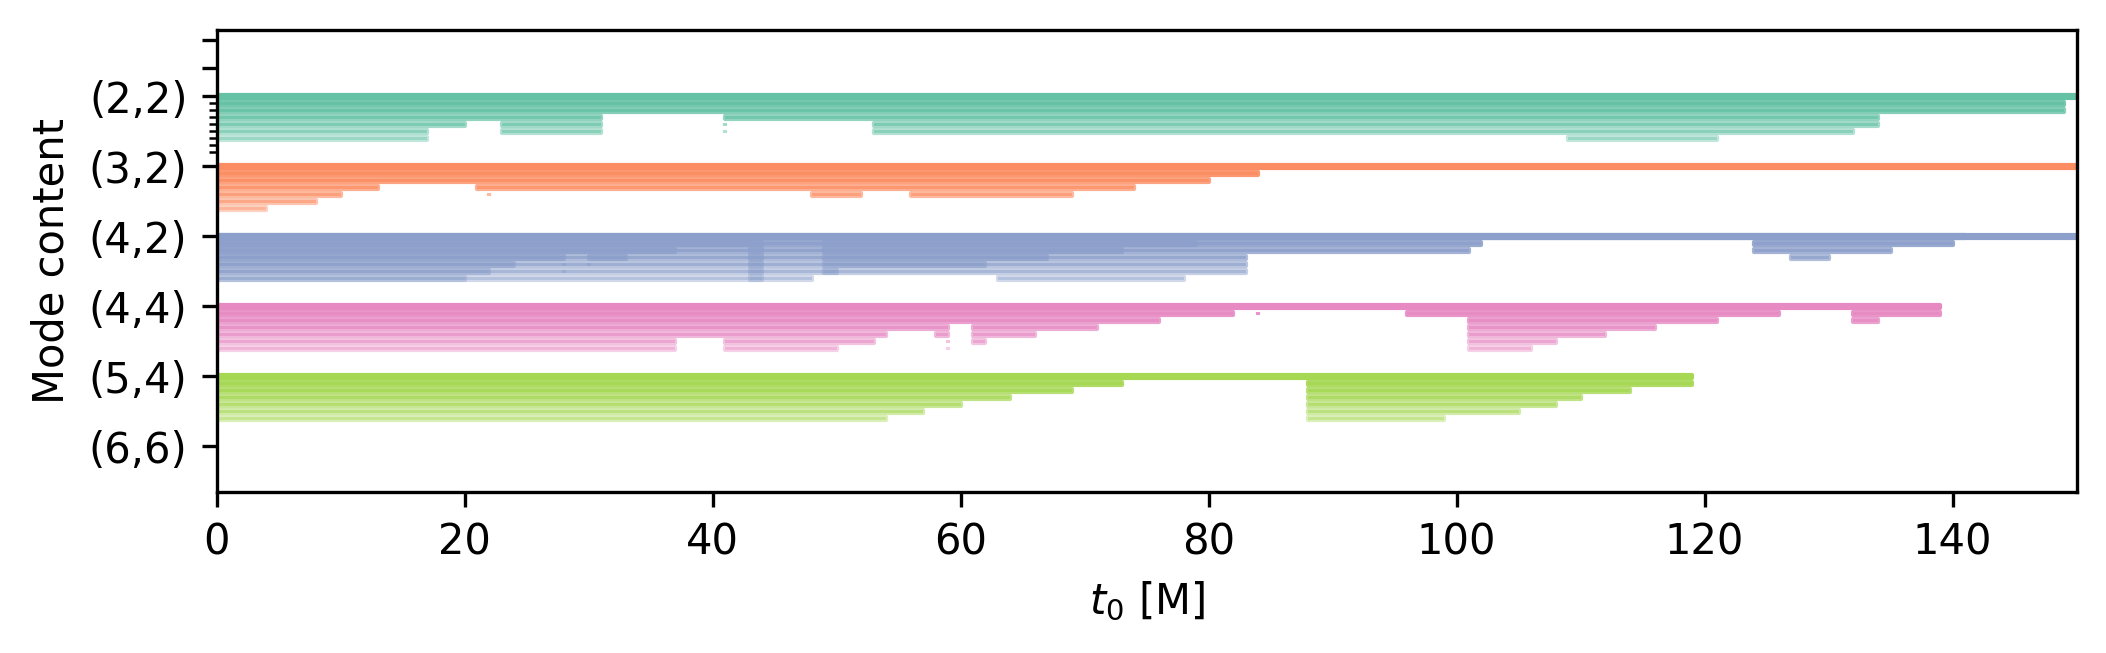

In [ ]:
eps = 0.25

sns.color_palette()

fig, ax = plt.subplots(figsize=(8, 2), dpi=300)

all_modes = ( [(2,2,n,1) for n in range(0, 7)] + \
                        [(3,2,n,1) for n in range(0, 7)] + \
                        [(4,2,n,1) for n in range(0, 7)] + \
                        [(4,4,n,1) for n in range(0, 7)] + \
                        [(5,4,n,1) for n in range(0, 7)] + \
                        [(6,6,n,1) for n in range(0, 7)]) 

# Use the all_modes variable already defined in the notebook
for mode in all_modes:
    l_max, n_max = 6, 7

    # Position each mode line separately as in the original code
    if len(mode) == 4:
        l, m, n, p = mode
        y = -(l-2) * 10 - n
    elif len(mode) == 8:
        l, m, n, p, L, M, N, P = mode
        y = 8
    elif len(mode) == 12:
        l, m, n, p, L, M, N, P, _, _, _, _ = mode
        y = 4

    runs = masks(mode, modes)
    for i, run in enumerate(runs):
        label = None
        if i == 0:
            label = (None if len(mode) == 4 else (r"$(2,2,0,+)^2$" if len(mode) == 8 else r"$(2,2,0,+)^3$"))
        ax.fill_between(
            t0_vals[run],
            [y-eps for t0 in t0_vals[run]],
            [y-1+eps for t0 in t0_vals[run]],
            alpha=1-0.1*n if len(mode) == 4 else 1,
            color=(colors[l-2] if len(mode) == 4 else (colors[5] if len(mode) == 8 else colors[6])),
            label=label
        )

ax.set_xlabel(r"$t_0$ [M]")
ax.set_ylabel(r"Mode content")

ax.set_xlim(0, 150)
ax.set_ylim(-(l_max-2) * 12 - n_max - 2, 9)

ticks = [-0.5, -10.5, -20.5, -30.5, -40.5, -50.5, 3.5, 7.5]
minor_ticks = [-1.5, -2.5, -3.5, -4.5, -5.5, -6.5, -7.5, -8.5]
tick_labels = ["(2,2)", "(3,2)", "(4,2)", "(4,4)", "(5,4)", "(6,6)", "", ""]

ax.set_yticks(ticks)
ax.yaxis.set_minor_locator(FixedLocator(minor_ticks))
ax.set_yticklabels(tick_labels)

ax.legend(loc='upper right', frameon=False, fontsize=6,
          bbox_to_anchor=(1., 1.), handlelength=1., handleheight=0.3,
          borderpad=0., labelspacing=0.5, ncol=2)

plt.show()


ValueError: The number of FixedLocator locations (8), usually from a call to set_ticks, does not match the number of labels (6).

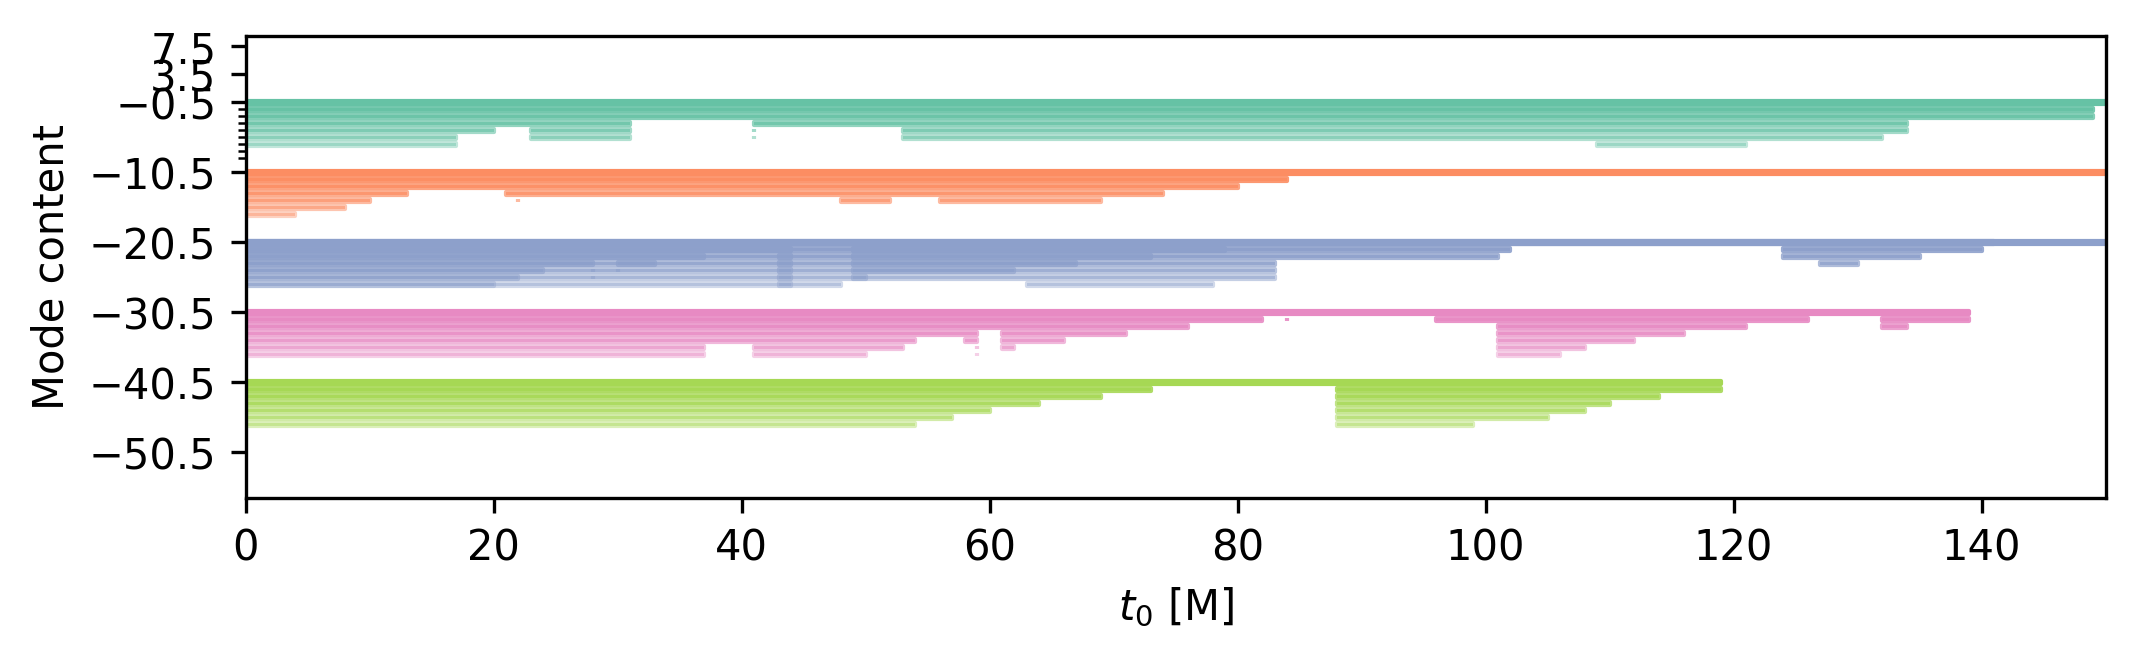

In [38]:
eps = 0.25

sns.color_palette()

fig, ax = plt.subplots(figsize=(8, 2), dpi=300)

all_modes = ( [(2,2,n,1) for n in range(0, 8)] + \
              [(3,2,n,1) for n in range(0, 8)] + \
              [(4,2,n,1) for n in range(0, 8)] + \
              [(4,4,n,1) for n in range(0, 8)] + \
              [(5,4,n,1) for n in range(0, 8)] + \
              [(6,6,n,1) for n in range(0, 8)] + \
              [(2,2,0,1,2,2,0,1)] + \
              [(2,2,0,1,2,2,0,1,2,2,0,1)])

for mode in all_modes:

    l_max, n_max = 6, 7

    if len(mode) == 4:
        l, m, n, p = mode
        y = -(l-2) * 10 - n
    elif len(mode) == 8:
        l, m, n, p, L, M, N, P = mode
        y = 8
    elif len(mode) == 12:
        l, m, n, p, L, M, N, P, _, _, _, _ = mode
        y = 4

    runs = masks(mode, modes)
    
    for i, run in enumerate(runs):

        label = None
        if i==0:
            label = (None if len(mode)==4 else (r"$(2,2,0,+)^2$" if len(mode)==8 else r"$(2,2,0,+)^3$"))

        ax.fill_between(
            t0_vals[run],
            [y-eps for t0 in t0_vals[run]],
            [y-1+eps for t0 in t0_vals[run]],
            alpha=1-0.1*n,
            color=(colors[l-2] if len(mode)==4 else (colors[5] if len(mode)==8 else colors[6])),
            label=label
        )

ax.set_xlabel(r"$t_0$ [M]")
ax.set_ylabel(r"Mode content")

ax.set_xlim(0, 150)
ax.set_ylim(-(l_max-2) * 12 - n_max - 2, 9)

ticks = [-0.5, -10.5, -20.5, -30.5, -40.5, -50.5, 3.5, 7.5]
minor_ticks = [-1.5, -2.5, -3.5, -4.5, -5.5, -6.5, -7.5, -8.5]
tick_labels = ["(2,2)", "(3,2)", "(4,2)", "(4,4)", "(5,4)", "(6,6)", "", ""]

ax.set_yticks(ticks)
ax.yaxis.set_minor_locator(FixedLocator(minor_ticks))
ax.set_yticklabels(tick_labels)

ax.legend(loc='upper right', frameon=False, fontsize=6,
          bbox_to_anchor=(1., 1.), handlelength=1., handleheight=0.3,
          borderpad=0., labelspacing=0.5, ncol=2)

plt.show()

In [36]:
fits = {}
for t0 in t0_vals:
    select_modes = modes[t0]
    select_modes = [tuple(mode) for mode in select_modes]
    fits[int(t0)] = bgp.BGP_fit(sim.times, 
                                sim.h, 
                                select_modes, 
                                sim.Mf, 
                                sim.chif_mag, 
                                tuned_param_dict_GP, 
                                bgp.kernel_GP, 
                                t0=t0, 
                                T=T, 
                                spherical_modes=SPHERICAL_MODES,
                                include_chif=True,
                                include_Mf=True,
                                data_type=DATA_TYPE)

KeyboardInterrupt: 

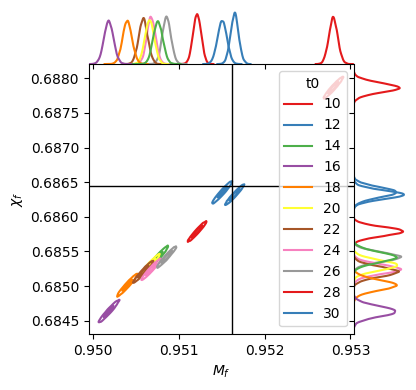

In [ ]:
t_range = np.arange(10, 32, 2)
dfs = []
for t in t_range:
    df_temp = pd.DataFrame({
        r'$M_f$': fits[t].fit["samples"][:,-1],
        r'$\chi_f$': fits[t].fit["samples"][:,-2],
        't0': np.full(len(fits[t].fit["samples"][:,-1]), t)
    })
    dfs.append(df_temp)
data = pd.concat(dfs, ignore_index=True)

fig = sns.jointplot(data=data, x=r'$M_f$', y=r'$\chi_f$', hue='t0', kind="kde", space=0, 
                    height=4, joint_kws={'levels':[0.1, 0.5]}, 
                    palette=sns.color_palette("Set1", len(t_range)))

fig.ax_joint.axvline(sim.Mf, lw=1, color='k', ls='-')
fig.ax_joint.axhline(sim.chif_mag, lw=1, color='k', ls='-')

plt.show()


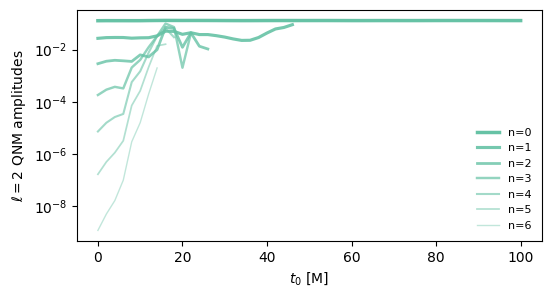

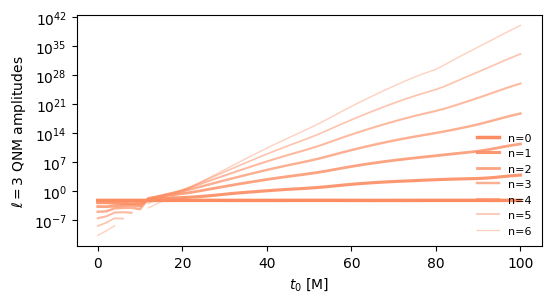

/tmp/ipykernel_2272798/3584875237.py:63: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower right', frameon=False, fontsize=8)


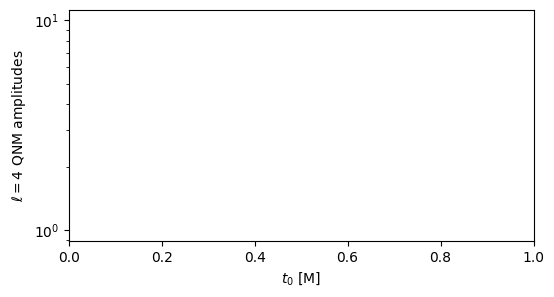

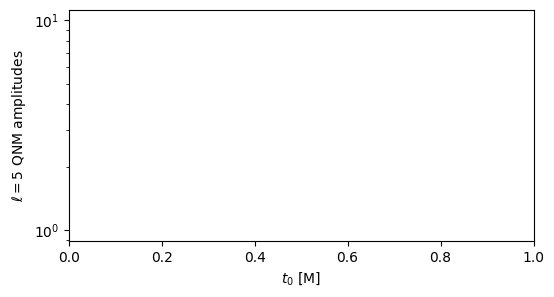

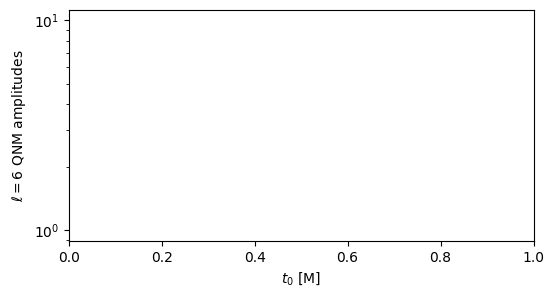

In [ ]:
for l in range(2, 7):

    fig, ax = plt.subplots(figsize=(6, 3))

    for n in np.arange(8):

        mode = (l, l if l%2==0 else l-1, n, 1)

        runs = masks(mode, modes)

        for j, run in enumerate(runs):

            temp_t0_vals = t0_vals[run]

            amps = np.zeros_like(temp_t0_vals)
            for i, t0 in enumerate(temp_t0_vals):
                idx = [list(mode) for mode in modes[t0]].index(list(mode))
                re = fits[t0].fit["samples"][:, 2*idx]
                im = fits[t0].fit["samples"][:, 2*idx+1]
                amps[i] = np.median(np.sqrt(re**2 + im**2))

            tau = qnmfits.qnm.omega(*mode, sim.chif_mag, Mf=sim.Mf).imag

            ax.plot(temp_t0_vals, amps*np.exp(-tau*(temp_t0_vals-TREF)),
                    color=colors[l-2], alpha=1-0.1*n, lw=2.5-0.25*n,
                    label=f'{n=}' if j==0 else None)
            
    if l==4:
        mode = (2,2,0,1,2,2,0,1)
        runs = masks(mode, modes)
        for j, run in enumerate(runs):
            temp_t0_vals = t0_vals[run]
            amps = np.zeros_like(temp_t0_vals)
            for i, t0 in enumerate(temp_t0_vals):
                re = fits[t0].fit["samples"][:, 2*n]
                im = fits[t0].fit["samples"][:, 2*n+1]
                amps[i] = np.median(np.sqrt(re**2 + im**2))
            tau = 2*qnmfits.qnm.omega(2,2,0,1, sim.chif_mag, Mf=sim.Mf).imag
            ax.plot(temp_t0_vals, amps*np.exp(-tau*(temp_t0_vals-TREF)),
                    color=colors[5], alpha=1, lw=1.5,
                    label=r'$(2,2,0,1)^2$' if j==0 else None)
            
    if l==6:
        mode = (2,2,0,1,2,2,0,1,2,2,0,1)
        runs = masks(mode, modes)
        for j, run in enumerate(runs):
            temp_t0_vals = t0_vals[run]
            amps = np.zeros_like(temp_t0_vals)
            for i, t0 in enumerate(temp_t0_vals):
                re = fits[t0].fit["samples"][:, 2*n]
                im = fits[t0].fit["samples"][:, 2*n+1]
                amps[i] = np.median(np.sqrt(re**2 + im**2))
            tau = 3*qnmfits.qnm.omega(2,2,0,1, sim.chif_mag, Mf=sim.Mf).imag
            ax.plot(temp_t0_vals, amps*np.exp(-tau*(temp_t0_vals-TREF)),
                    color=colors[6], alpha=1, lw=1.5,
                    label=r'$(2,2,0,1)^3$' if j==0 else None)

    ax.set_xlabel(r"$t_0$ [M]")
    ax.set_ylabel(r"$\ell="+str(l)+"$ QNM amplitudes")

    ax.set_yscale('log')

    ax.legend(loc='lower right', frameon=False, fontsize=8)

    plt.show()